In [3]:
import iCLIP
import pandas
import CGAT.Database as Database
%load_ext rpy2.ipython
import CGATPipelines.Pipeline as P

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
P.getParameters("/ifs/projects/proj028/project_pipeline_iCLIP5/pipeline.ini")
annotations = P.PARAMS["annotations_database"]

In [5]:
db = "/ifs/projects/proj028/project_pipeline_iCLIP5/csvdb"
annotations = "ATTACH '%s' as annotations" % annotations
counts = Database.fetch_DataFrame('''SELECT DISTINCT cc.gene_id, cc.exon_id,
                                   cc.*,
                                   first,
                                   last,
                                   exon,
                                   intron
                     FROM chunk_counts as cc
                      INNER JOIN annotations.gene_stats as gs
                       ON gs.gene_id = cc.gene_id
                      INNER JOIN annotations.gene_info as gi
                       ON cc.gene_id = gi.gene_id
                      INNER JOIN reference_chunks_expressed_transcripts_gene_first_pc_exons as fe
                       ON fe.gene_id = cc.gene_id AND
                          fe.exon_id = cc.exon_id
                      INNER JOIN reference_chunks_expressed_transcripts_gene_last_pc_exons as le
                       ON le.gene_id = cc.gene_id AND
                          le.exon_id = cc.exon_id 
                      INNER JOIN reference_chunks_expressed_exons as ce
                       ON ce.gene_id = cc.gene_id AND
                          ce.exon_id = cc.exon_id
                      INNER JOIN reference_chunks_expressed_introns as ie
                       ON ie.gene_id = cc.gene_id AND
                          ie.exon_id = cc.exon_id
                      INNER JOIN reference_chunks_ngenes as ng
                       ON ng.gene_id = cc.gene_id AND
                          ng.exon_id = cc.exon_id
                      WHERE ng.ngenes == 1
                        AND gene_biotype=='protein_coding'
                        AND contig != 'chrM'
                     ''', db, annotations)

In [6]:
counts.head()

,gene_id,exon_id,ALYREF_Cytoplasmic_R1,ALYREF_Cytoplasmic_R2,ALYREF_Nuclear_R1,ALYREF_Nuclear_R2,ALYREF_Total_R1,ALYREF_Total_R2,Alyref_FLAG_R1,Alyref_FLAG_R2,...,eIF4A3_GFP_R1,eIF4A3_GFP_R2,eIF4A3_GFP_R3,eIF4A3_GFP_union,exon_id,gene_id,first,last,exon,intron
0,ENSG00000000003,1,1151.0,1280.0,1381.0,2436.0,946.0,1778.0,0.0,5.0,...,0.0,2.0,1.0,3.0,1,ENSG00000000003,0,1,1,0
1,ENSG00000000003,2,14.0,28.0,15.0,34.0,5.0,18.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2,ENSG00000000003,0,0,0,1
2,ENSG00000000003,3,311.0,367.0,397.0,605.0,243.0,505.0,0.0,1.0,...,0.0,1.0,0.0,1.0,3,ENSG00000000003,0,0,1,0
3,ENSG00000000003,4,13.0,19.0,35.0,45.0,20.0,23.0,0.0,1.0,...,0.0,0.0,0.0,0.0,4,ENSG00000000003,0,0,0,1
4,ENSG00000000003,5,74.0,88.0,75.0,149.0,56.0,119.0,0.0,0.0,...,0.0,1.0,0.0,1.0,5,ENSG00000000003,0,0,1,0


In [7]:
def grouping(row):
        if row["intron"]>0 and row["exon"]==0:
            return "intron"
        elif row["first"]>=1 :
            return "first"
        elif row["last"]>=1 :
            return "last"
        elif  row["intron"]==0:
            return "CDS"
        else:
            return None

In [8]:
counts["grouping"] = counts.apply(grouping, axis=1 )

In [9]:
alyref = counts.groupby("grouping").apply(lambda x: iCLIP.random.ratio_and_ci(
                                           test=x["Alyref_FLAG_union"],
                                           control=x["FlipIn_FLAG_union"]))

In [10]:
chtop = counts.groupby("grouping").apply(lambda x: iCLIP.random.ratio_and_ci(
                                           test=x["Chtop_FLAG_union"],
                                           control=x["FlipIn_FLAG_union"]))

In [11]:
nxf1 = counts.groupby("grouping").apply(lambda x: iCLIP.random.ratio_and_ci(
                                           test=x["Nxf1_FLAG_union"],
                                           control=x["FlipIn_FLAG_union"]))

In [12]:
exon_profiles = pandas.concat({"Alyref": alyref, "Chtop": chtop, "Nxf1": nxf1},
                              names = ("factor", "grouping")).reset_index()
exon_profiles

,factor,grouping,q0.025,q0.975,ratio
0,Alyref,CDS,35.520086,38.745294,37.254166
1,Alyref,first,43.578199,51.089671,46.904712
2,Alyref,intron,11.148454,11.546780,11.349101
3,Alyref,last,30.633197,33.407520,32.050866
4,Chtop,CDS,25.961166,28.635219,27.369980
5,Chtop,first,28.162033,33.915254,30.820942
6,Chtop,intron,5.300687,5.502944,5.396481
7,Chtop,last,50.991777,56.729897,53.758988
8,Nxf1,CDS,4.318446,4.565032,4.434840
9,Nxf1,first,4.455984,5.227578,4.803141


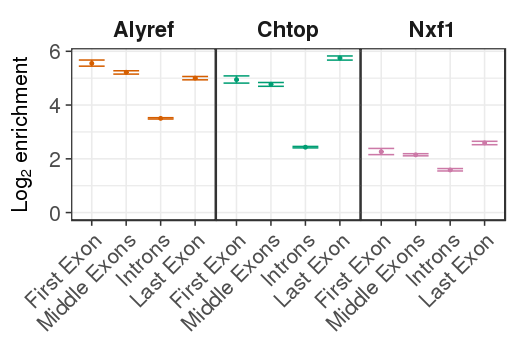

In [24]:
%%R -i exon_profiles -h 2 -w 3 -r 172 -u in

library(ggplot2)

ggplot(exon_profiles) +
    aes(x=grouping, y=log2(ratio), ymin=log2(q0.025), ymax=log2(q0.975), color=factor, group=1,
       ) +
    facet_grid(~factor, scale="free_y") +
    geom_point(size=0.3)+
    geom_errorbar(size=0.3, lwd=0.3, width=0.75) +
    scale_x_discrete(limits=c("first", "CDS",  "intron","last"),
                     labels=c("First Exon", "Middle Exons", "Introns", "Last Exon"),
                     name=NULL) +
    scale_color_manual(values=c("Alyref"="#D55E00", "Chtop"="#009E73", "Nxf1"="#CC79A7"), guide=FALSE) +
    scale_y_continuous(limits=c(0,NA), name = expression(paste(Log[2], " enrichment"))) +
    scale_size_manual(values=c(0.3, 1), guide=FALSE) +
    theme_bw(base_size=9) + 
    theme(line=element_line(size=0.3),
          strip.background = element_blank(),
          strip.text = element_text(margin=margin(1,1,2,1),
                                    size=9,
                                   face="bold"),
          axis.text = element_text(size=9),
          axis.text.x = element_text(angle=45, hjust=1),
          panel.spacing=unit(0,"lines")) -> g
ggsave("imgs/fig1g.pdf", g, width=3, height=1.75, units="in", useDingbats=FALSE)
print(g)

[Download PDF here](imgs/fig1g.pdf)